# Clustering
Regrouper des textes

In [1]:
# Import
# import spacy
# import datetime as dt
# from collections import Counter
# from random import sample
# import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import data
import pandas as pd
data_path = "../data/"
df = pd.read_pickle(data_path+"df_2017_avec_auteurs.pkl")

In [3]:
# Choix du corpus
dfh = df[df.rubrique.apply(lambda x : x in set(df.rubrique.head(5)))]
corpus = dfh.question
len(corpus)

1158

In [4]:
# Rubriques correspondantes sous forme d'entier
l_r = list(dfh.rubrique.unique())
dic_r = {l_r[i] : i for i in range(len(l_r))}
rubint = dfh.rubrique.apply(lambda x : dic_r[x])

In [5]:
# Groupes correspondants sous forme d'entier
l_g = list(dfh.groupe_auteur.unique())
dic_g = {l_g[i] : i for i in range(len(l_g))}
groupint = dfh.groupe_auteur.apply(lambda x : dic_g[x])

## A. TFIDF
Calcul du tf-idf

In [6]:
from stop_words import get_stop_words
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = get_stop_words('french')
vec = TfidfVectorizer(stop_words=stop_words)
vec.fit(corpus)
features = vec.transform(corpus)

## B. Clustering en s'apuyant sur la matrice des tf-idf ou des occurrences

## B.1 k-means
Prendre un corpus de documents, vectoriser avec tf idf, kmeans dessus. From https://sanjayasubedi.com.np/nlp/nlp-with-python-document-clustering/
Voir https://scikit-learn.org/stable/modules/clustering.html pour clustering on python
### B.1.1 Calcul du k-means

In [7]:
from sklearn.cluster import MiniBatchKMeans
random_state = 0
cls = MiniBatchKMeans(n_clusters=5, random_state=random_state)
cls.fit(features)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=0, reassignment_ratio=0.01,
                tol=0.0, verbose=0)

### B.1.2 Calcul de l'ACP et affichage

In [8]:
# reduce the features to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

# Print sing values
ordre0 = abs(pca.components_)[0].argsort()[::-1]
ordre1 = abs(pca.components_)[1].argsort()[::-1]

nbb = 10
print([vec.get_feature_names()[i] for  i in ordre0[:nbb]],"\n ============== \n",
[vec.get_feature_names()[i] for  i in ordre0[-nbb:]],"\n ============== \n",
[vec.get_feature_names()[i] for  i in ordre1[:nbb]],"\n ============== \n",
[vec.get_feature_names()[i] for  i in ordre1[-nbb:]])

['maladie', 'lyme', 'prise', 'santé', 'charge', 'cancer', 'patient', 'service', 'carte', 'ant'] 
 ['transgender', 'bois', 'trod', 'tran', '23', 'sydney', 'galles', 'bisexuel', 'avs', 'orient'] 
 ['cancer', 'école', 'enfant', 'euro', 'pédiatrique', 'million', 'maladie', 'compte', 'administration', 'lyme'] 
 ['réactiver', 'laconique', 'berta', 'biomarqueur', 'neurobiologique', 'illisibilité', 'investit', 'xxi', 'neuroscience', 'externalisation']


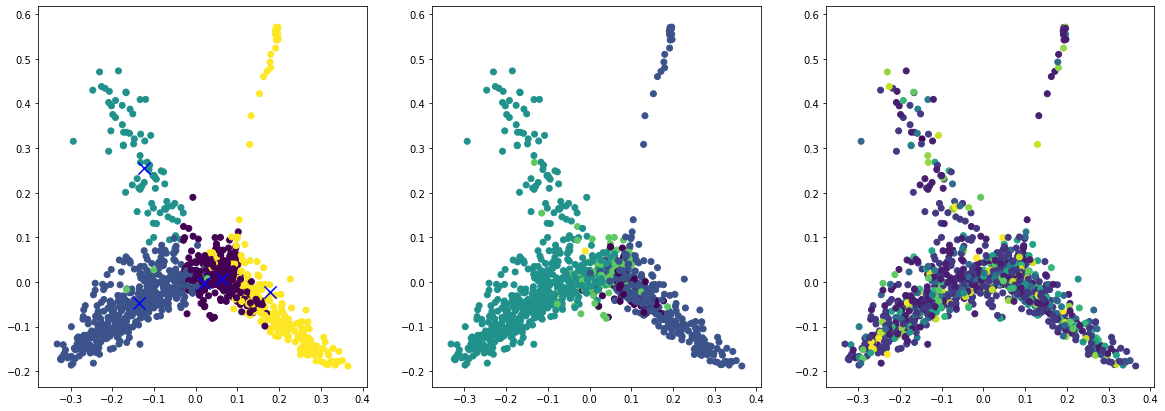

In [9]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,3,figsize = (20,7))
axes[0].scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
axes[0].scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')
axes[1].scatter(reduced_features[:,0], reduced_features[:,1], c=rubint)
axes[2].scatter(reduced_features[:,0], reduced_features[:,1], c=groupint)

## B.2 Ward HAC
https://chrisalbon.com/machine_learning/clustering/agglomerative_clustering/

### B.2.1 Clustering hac

In [10]:
# Create meanshift object
from sklearn.cluster import AgglomerativeClustering
clt = AgglomerativeClustering(linkage='complete', 
                              affinity='euclidean', 
                              n_clusters=3)

# Train model
model = clt.fit(features.toarray())

### B.2.2 ACP et affichage

In [11]:
# reduce the features to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())

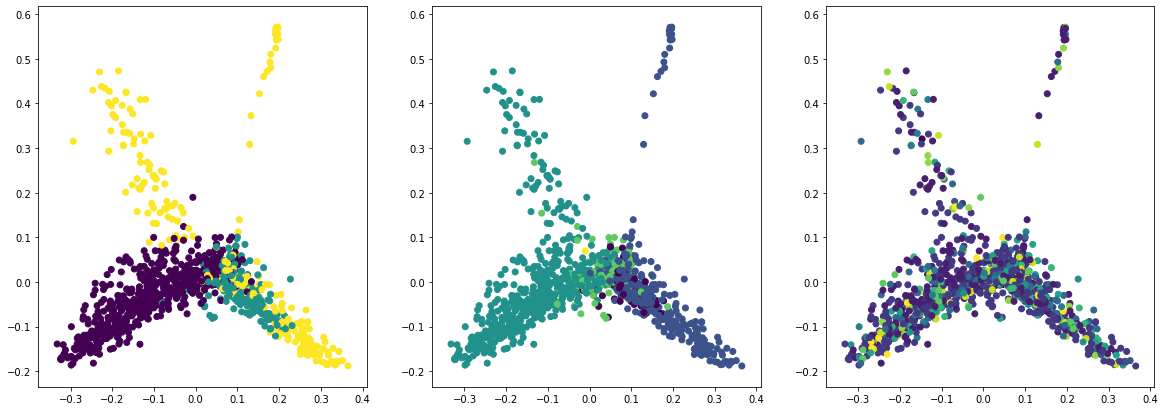

In [12]:
fig, axes = plt.subplots(1,3,figsize = (20,7))
axes[0].scatter(reduced_features[:,0], reduced_features[:,1], c=model.labels_)
axes[1].scatter(reduced_features[:,0], reduced_features[:,1], c=rubint)
axes[2].scatter(reduced_features[:,0], reduced_features[:,1], c=groupint)

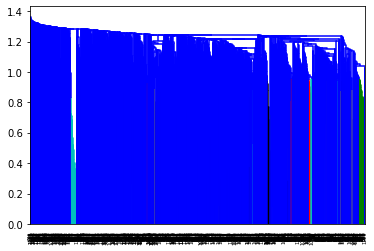

In [13]:
# Dendogramme associé
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(features.toarray());
dendrogram(Z);

## B.3 Ananlyse Sémantique Latente LSA

### B.3.1 Décomposition en valeurs singulières

In [14]:
from sklearn.decomposition import TruncatedSVD

k = 5 # Pas bon du tout, tenter de voir les meilleures valeurs singulières

svd_model = TruncatedSVD(n_components=5, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(features.T)

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=100,
             random_state=122, tol=0.0)

### B.3.2 Affichage des topics repérés

In [15]:
terms = vec.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ",end= ' ')
    for t in sorted_terms:
        print(t[0],end=' ')
    print('')

Topic 0:  affronter amiant alzheimer 38 affirment 359 abandon 
Topic 1:  administrativement 38 adulte agent 64 alzheimer 359 
Topic 2:  accru accroître accorde accroissement accueil accompagnement accompagnemer 
Topic 3:  accentue accélèrer acarbose accidentel 450 aboutissement 923 
Topic 4:  780 artisan 114 185 1755 1987 administratif 


### B.3.3 Affichage  UMAP et CAHdu clustering

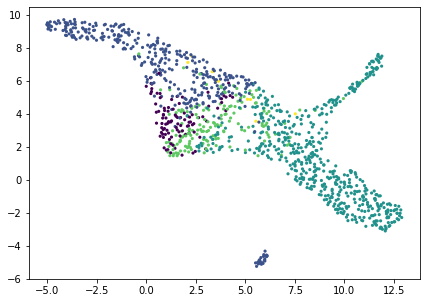

In [16]:
from umap import UMAP

X_topics = svd_model.fit_transform(features)
embedding = UMAP(n_neighbors=100, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
c = rubint,
s = 10, # size
edgecolor='none')
plt.show()

### B.3.4 Tests cosine distance

In [17]:
# reduce the features to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(X_topics)

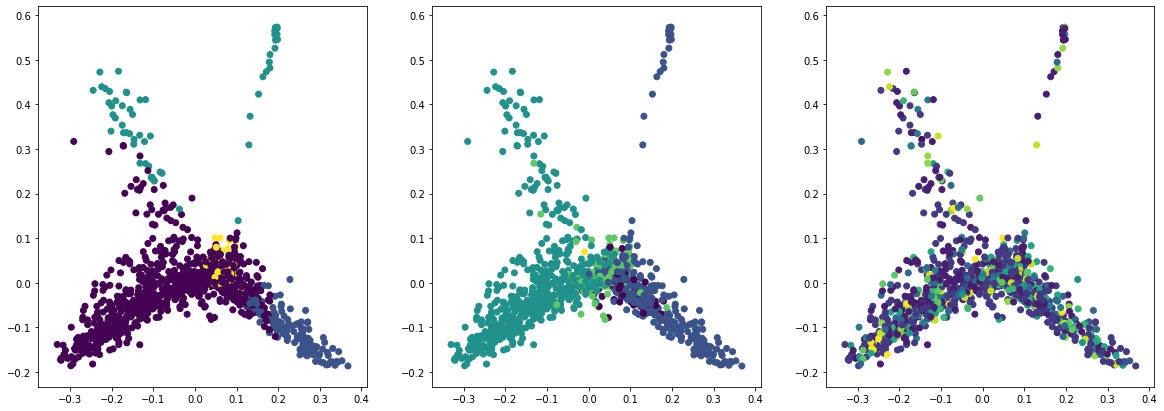

In [18]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,3,figsize = (20,7))
axes[0].scatter(reduced_features[:,0], reduced_features[:,1], c=np.argmax(X_topics,axis= 1))
axes[1].scatter(reduced_features[:,0], reduced_features[:,1], c=rubint)
axes[2].scatter(reduced_features[:,0], reduced_features[:,1], c=groupint)

## B.4 Allocation de Dirichlet Latente et Factorisation de Matrices non-Négatives
https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic {}".format(topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
no_features = len(corpus)

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(corpus)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(corpus)
tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 5

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_doc_topics = [i.argmax() for i in nmf.components_.T]

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_doc_topics = [i.argmax() for i in lda.components_.T]

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, tf_feature_names, no_top_words)

Topic 0
maladie prise charge santé patient lyme personne atteindre malade fibromyalgie
Topic 1
carte gris ant titre service préfecture usager site délai véhicule
Topic 2
cancer enfant pédiatrique recherche dépistage financement décès 500 pourcent parent
Topic 3
école compte euro million administration facture redressement déficit afficher crédibilité
Topic 4
français social étranger sécurité se france public pouvoir ne personne
Topic 0
personne caf activité allocation bénéficier handicapé prime déclaration adulte site
Topic 1
service demande se permettre public état délai administration site titre
Topic 2
social se public mme sécurité ne pouvoir personne travail santé
Topic 3
français étranger cancer france se enfant pouvoir ne pays recherche
Topic 4
maladie santé patient personne charge mme prise se solidarité pouvoir


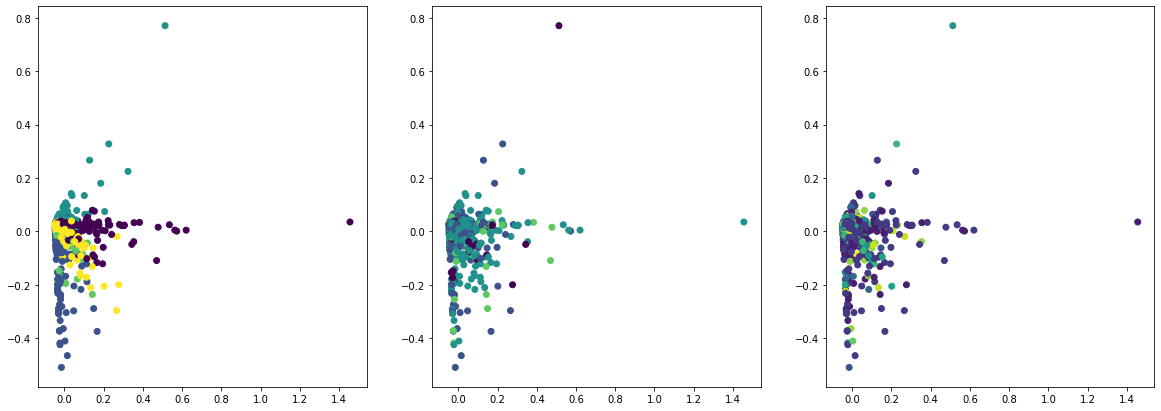

In [20]:
# reduce the features to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(nmf.components_.T)
fig, axes = plt.subplots(1,3,figsize = (20,7))
axes[0].scatter(reduced_features[:,0], reduced_features[:,1], c=nmf_doc_topics)
axes[1].scatter(reduced_features[:,0], reduced_features[:,1], c=rubint)
axes[2].scatter(reduced_features[:,0], reduced_features[:,1], c=groupint)

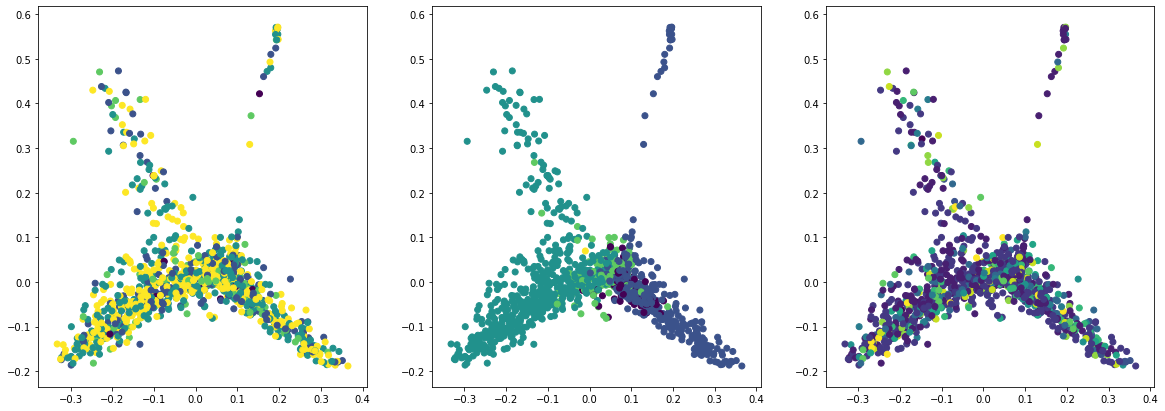

In [21]:
# reduce the features to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())
fig, axes = plt.subplots(1,3,figsize = (20,7))
axes[0].scatter(reduced_features[:,0], reduced_features[:,1], c=lda_doc_topics)
axes[1].scatter(reduced_features[:,0], reduced_features[:,1], c=rubint)
axes[2].scatter(reduced_features[:,0], reduced_features[:,1], c=groupint)

# D Distances entre députés

In [191]:
# Fonction calculant les distances entre lettres
from scipy.spatial import distance_matrix
def matrix_distances(docs_vec,maxd = 100):
    """ docs_vec : les vecteurs de chaque document
        maxd : nombre maximal de documents dans la matrice
        retourne la matrice des distances 
    """
    return distance_matrix(docs_vec[:maxd],docs_vec[:maxd])#,p = docs_vec.shape[1])

def matrix_index(p,n):
    """Return the index of pos p in a n*n matrix"""
    return (p//n,p%n)

def pair_distances(docs_vec,maxd = 100):
    """
    retourne les paires de docments avec leur distances correspondances"""
    dstm = matrix_distances(docs_vec,maxd)    
    return pd.DataFrame([(i,j,dstm[i][j]) for i in range(maxd) for j in range(i)],columns = ['a','b','val']).sort_values(by = 'val').reset_index(drop = True)

def compare_corpus(padi,corpus,idx):
    """Montre les deux documents du corpus correspondant à l'indice demandé"""
    a,b,v = padi.loc[idx,]
    print("Lien {} de valeur {} :".format(idx,v))
    print(corpus.values[[int(a),int(b)]])

Lien 10 de valeur 0.9616782646812451 :
['m. jean-yves bony appeler attention mme ministre solidarité santé situation personne atteindre borréliose lyme . maladie lyme pathologie infectieux conséquence douloureux durable touche année millier malade france . force constater échappe souvent al test dépistage pourtant , ne pouvoir traiter diagnostiquer rapidement . or fiabilité test sérologique actuellement commercialiser semble remettre cause spécialiste . pourtant , accès soin indemnisation malade sécurité social conditionner seul test . système santé français appréhende manière imparfait pathologie interdire nombreux traitement semblent efficacer . volet viser améliorer diagnostic prise charge patient , précéder gouvernement prévoir ouverture centre dépistage traitement regrouper spécialité impliquer . demande point mise place centre , notamment cantal préciser avancée plan national lutte borréliose lyme proposer gouvernement durant quinquennat 2012 - 2017 .'
 "m. yannick favennec becot

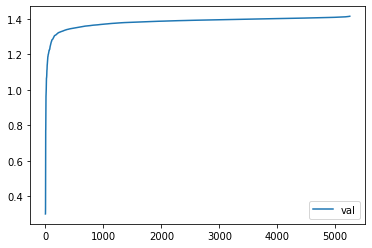

In [193]:
# Clacul avec les features du tfidf, IMPOSSOBLE CAR DIMENSION ENORME : BIZARE BIZARE CAR FONCTIONNE AVEC p = 2
vc = features.toarray()
padi = pair_distances(vc,103)
padi.plot(y='val')
compare_corpus(padi,corpus,10)

Lien 0 de valeur 0.0005025564404921643 :
['m. joël aviragnet attire attention mme ministre solidarité santé problème mutuelle intérimaire . nombreux salarié poser question fonctionnement mutuelle obligatoire proposer société intérimaire . semble - delà information souvent déficient employeur , mission quelque jour demander démarche complexe , dispositif est-il adapter mission court durée ? - delà problème portabilité , salarié se retrouver obligation payer deuxième mutuelle pouvoir favorable terme prise charge soin . , demande bien vouloir indiquer orientation gouvernement .'
 "m. martial saddier attire attention mme ministre solidarité santé double affiliation travailleur frontalier . premier juin 2015 , frontalier français bénéficier droit option , donner choix système santé suisse , sécurité social français assurance priver français . date , frontalier opter dernier option automatiquement affilier régime assurance maladie français ( cmu ) . or arrêt prendre 10 mars 2015 , tribunal f

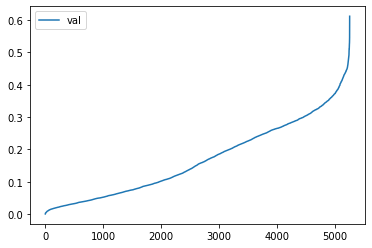

In [194]:
# Clacul avec les reduced features du tfidf
reduced_features = pca.fit_transform(features.toarray())
vc = reduced_features
padi = pair_distances(vc,103)
padi.plot(y='val')
compare_corpus(padi,corpus,0)

Lien 0 de valeur 0.001989577146023864 :
["mme barbara pompili attire attention mme ministre solidarité santé recherche cystite interstitiel . maladie vessie se révéler souvent handicapant fort douleur qu' pouvoir causer . environ 10 000 personne atteindre france . cause pathologie restent jour inconnu . diagnostic ne se effectue souvent élimination . conséquence , traitement médical souvent inefficace patient se trouver situation errance médical . apparaître nécessaire , traiter maladie , stimuler recherche scientifique , notamment cause pathologie . faciliter diagnostic , protocole diagnostic précis pouvoir défini , notamment détecter présence substance appelée « facteur antiprolifératif » , présente uniquement patient atteindre maladie . protocole pouvoir effet permettr éviter patient subir examen invasif douloureux . sensibilisation médecin , généraliste spécialiste , reste parfois faible . conséquence maladie devoir également appeler réponse pouvoir public , tant pouvoir lourder vi

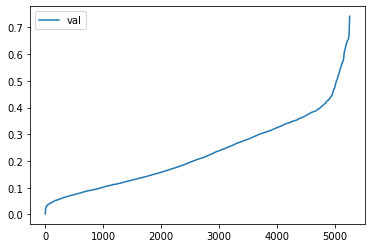

In [196]:
# Clacul avec les le LSA
vc = X_topics
padi = pair_distances(vc,103)
padi.plot(y='val')
compare_corpus(padi,corpus,0)

Lien 0 de valeur 0.0006672295475229175 :
["m. patrick hetzel alerte m. ministre état , ministre intérieur , situation qu' engendre évolution système immatriculation entreprise activité fabrication véhicule destiner transport personne mobilité réduit . métier carrossier constructeur consiste réaliser aménagement véhicule . or , suppression service carte gris préfecture , entreprise transmettre dossier al différent cert répartir territoire national voie électronique partir plateforme prévoir effet ( immatriculation pv rti ) . malheureusement , service ne réalise mission conséquence empêcher immatriculer ainsi bloquer livraison véhicule produire . somme , aujourd'hui société ne mesure livrer véhicule qu' produire raison dysfonctionnement service état . dossier transmettre ne traiter . préfecture , délivrance certificat immatriculation se 24 48 heure . or jour 3 semaine fonctionnement quasiment aucun certificat immatriculation n' délivrer nationalemer cert . véhicule produire ne pouvoir li

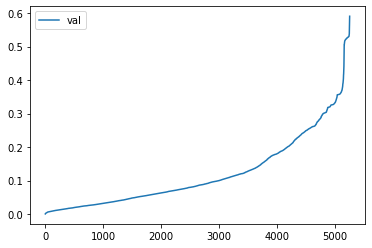

In [197]:
# Clacul avec le nmf
vc = nmf.components_.T
padi = pair_distances(vc,103)
padi.plot(y='val')
compare_corpus(padi,corpus,0)

Lien 0 de valeur 0.7905621337051418 :
["m. thomas mesnier attire attention mme ministre solidarité santé prise charge trouble associer traitement cataracte . près 800 000 intervention année , opération cataracte opération pratiquer france . développement technologie médical ophtalmologie permettre aujourd'hui traiter , cours opération , cataracte trouble réfraction accommodation associer . permettre patient , âge moyen 74 an opération , ne porter lunette vue . autonomie confort vie sensiblement améliorer , accident vie quotidien mauvais vision occasion réduire . se agir enjeu important prévention santé public , accès innovation médical accompagnement vieillissement population . bénéfice évident revêtir double traitement cataracte trouble réfractif accommodation , vide juridique existe actuellement quant prise charge soin sécurité social . effet , traitement cataracte rembourser intégralement assurance maladie , traitement trouble réfraction accommodation reste grand partie charge patie

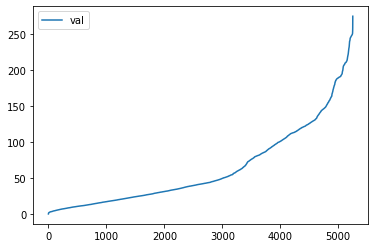

In [198]:
# Clacul avec le lda
vc = lda.components_.T
padi = pair_distances(vc,103)
padi.plot(y='val')
compare_corpus(padi,corpus,0)

## D.1 Distances vectorielles utilisant les vectorisations de documents précédentes
### D.1.1 Brut sur les scores de tf-idf 

In [ ]:
#

# C En s'appuyant sur du Word embedding
## C.1 Similarité entre textes puis k-means